In [ ]:
# Step 1–2: Sample data across the whole file using chunks

import pandas as pd
import numpy as np

# Specify which columns I need (keeps memory low)
usecols = [
    "event_time", "event_type", "product_id", "category_id",
    "category_code", "brand", "price", "user_id", "user_session"
]

def load_sampled_data(path, frac=0.02, chunksize=2_000_000, random_state=42):
    """
    Efficiently load a large CSV in chunks and randomly sample each chunk.
    
    Parameters:
        path (str): Path to the CSV file
        frac (float): Fraction of rows to sample per chunk (0.02 = 2%)
        chunksize (int): Number of rows to read at a time
        random_state (int): Seed for reproducible sampling
        
    Returns:
        DataFrame: Combined random sample covering all times & categories
    """
    pieces = []
    
    print("Starting chunked sampling...")
    
    for i, chunk in enumerate(pd.read_csv(path, usecols=usecols, chunksize=chunksize)):
        print(f" - Processing chunk {i+1}...")
        
        # Randomly sample the chunk
        sample = chunk.sample(frac=frac, random_state=random_state)
        pieces.append(sample)

    # Combine all sampled pieces
    df_sample = pd.concat(pieces, ignore_index=True)
    
    print("Sampling complete!")
    return df_sample


#  Load the sampled dataset 
csv_path = "../data/2019-Nov.csv"   # update path if needed

df = load_sampled_data(
    csv_path,
    frac=0.02,           # 2% sampling from each chunk
    chunksize=2_000_000  # process 2 million rows at a time
) #Because I wanted to run this on my local PC and had limited memory, I needed to randomize it.

print("\nFinal sample size:", df.shape)

# Convert event_time BEFORE checking time coverage
df["event_time"] = pd.to_datetime(df["event_time"], utc=True, errors="coerce")
df = df.dropna(subset=["event_time"])

# Extract hour and weekday for quick sanity checks
df["hour"] = df["event_time"].dt.hour
df["weekday"] = df["event_time"].dt.dayofweek

print("Time range:", df["event_time"].min(), "→", df["event_time"].max())
print("Unique weekdays in sample:", sorted(df["weekday"].unique()))
print("Hours covered:", df["hour"].min(), "→", df["hour"].max())


Starting chunked sampling...
 - Processing chunk 1...
 - Processing chunk 2...
 - Processing chunk 3...
 - Processing chunk 4...
 - Processing chunk 5...
 - Processing chunk 6...
 - Processing chunk 7...
 - Processing chunk 8...
 - Processing chunk 9...
 - Processing chunk 10...
 - Processing chunk 11...
 - Processing chunk 12...
 - Processing chunk 13...
 - Processing chunk 14...
 - Processing chunk 15...
 - Processing chunk 16...
 - Processing chunk 17...
 - Processing chunk 18...
 - Processing chunk 19...
 - Processing chunk 20...
 - Processing chunk 21...
 - Processing chunk 22...
 - Processing chunk 23...
 - Processing chunk 24...
 - Processing chunk 25...
 - Processing chunk 26...
 - Processing chunk 27...
 - Processing chunk 28...
 - Processing chunk 29...
 - Processing chunk 30...
 - Processing chunk 31...
 - Processing chunk 32...
 - Processing chunk 33...
 - Processing chunk 34...
Sampling complete!

Final sample size: (1350040, 9)
Time range: 2019-11-01 00:00:09+00:00 → 2019

In [ ]:
# Step 3: preprocessing & feature engineering 

# 1) Convert event_time to datetime
df["event_time"] = pd.to_datetime(df["event_time"], utc=True, errors="coerce")
df = df.dropna(subset=["event_time"])   # drop rows with invalid time

# 2) Fill missing category_code & brand
df["category_code"] = df["category_code"].fillna("unknown")
df["brand"] = df["brand"].fillna("unknown")

# 3) Drop rows with missing essential fields
df = df.dropna(subset=["event_type", "product_id", "user_id", "user_session"])

# 4) Remove duplicate events
df = df.drop_duplicates(subset=[
    "event_time", "event_type", "product_id",
    "category_id", "user_id", "user_session"
])

# 5) Filter unrealistic prices
df = df[(df["price"] > 0) & (df["price"] < df["price"].quantile(0.999))]

# 6) Add time-based features
df["date"] = df["event_time"].dt.date
df["hour"] = df["event_time"].dt.hour
df["weekday"] = df["event_time"].dt.dayofweek      # Monday=0
df["is_weekend"] = df["weekday"].isin([5, 6])

print("Shape after preprocessing:", df.shape)
df.head()


Shape after preprocessing: (1344788, 13)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour,weekday,date,is_weekend
0,2019-11-02 07:19:54+00:00,view,22700890,2053013556168753601,unknown,unknown,340.60,529349330,bac1e144-a4b2-478e-b4ba-507ba66d79c7,7,5,2019-11-02,True
1,2019-11-01 17:29:26+00:00,view,1003317,2053013555631882655,electronics.smartphone,apple,928.18,527642057,90a27642-1b7f-4f03-99e3-a9f04a6f41e2,17,4,2019-11-01,False
2,2019-11-01 05:23:06+00:00,view,1004322,2053013555631882655,electronics.smartphone,huawei,334.37,523210985,e7ab2f78-3076-499e-9a3f-f80c1a954f58,5,4,2019-11-01,False
3,2019-11-02 04:54:36+00:00,view,12100045,2053013555816432043,kids.skates,xiaomi,367.55,559864866,5635ab68-f7bf-411a-85c8-007f165ab463,4,5,2019-11-02,True
4,2019-11-01 05:20:07+00:00,view,4801607,2053013554658804075,electronics.audio.headphone,defender,10.30,566039229,0286726f-a676-4781-8baa-8091f2d79fe3,5,4,2019-11-01,False


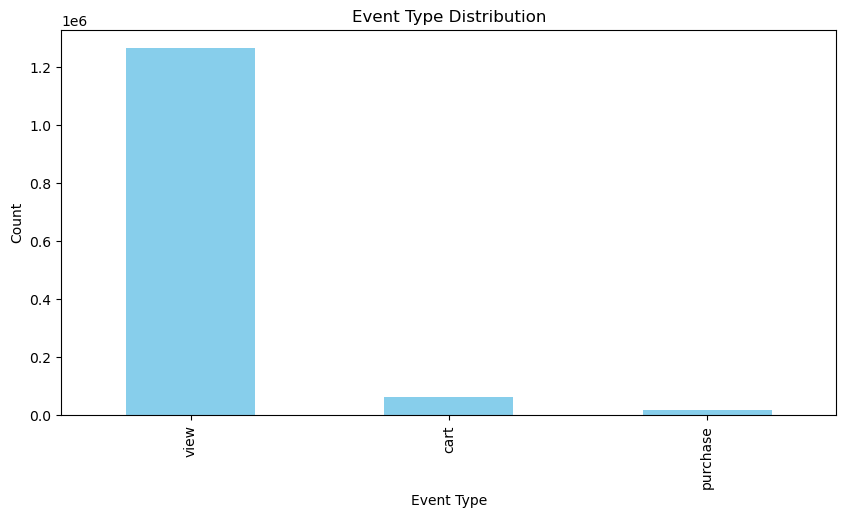

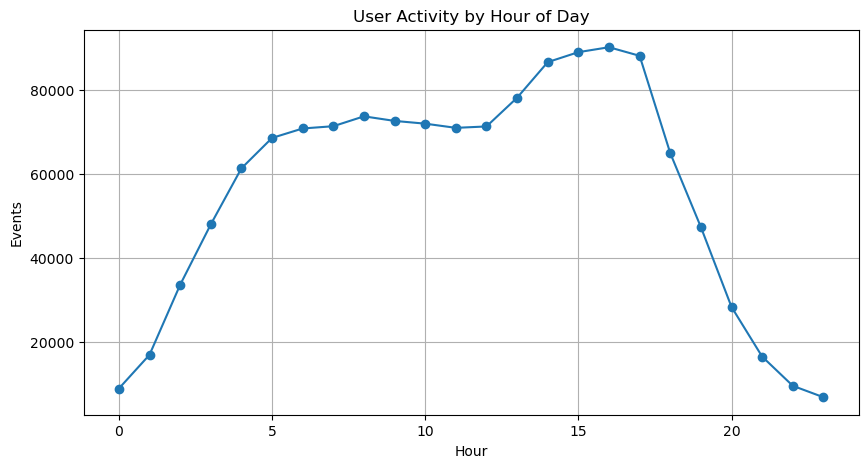

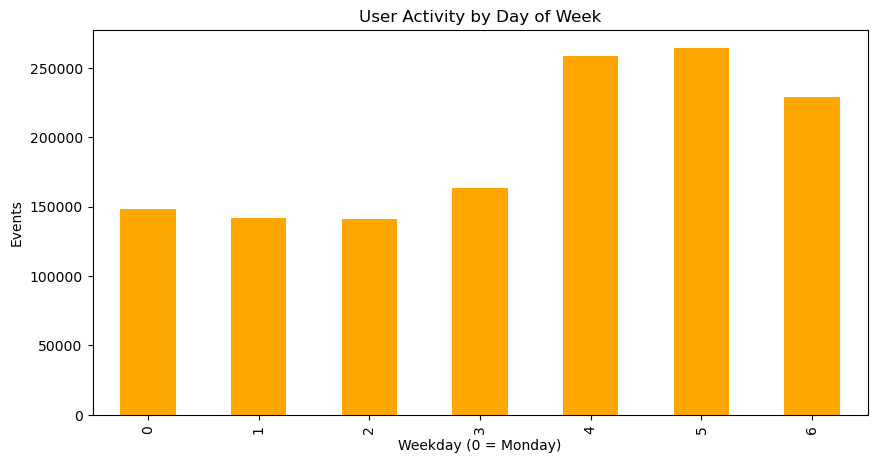

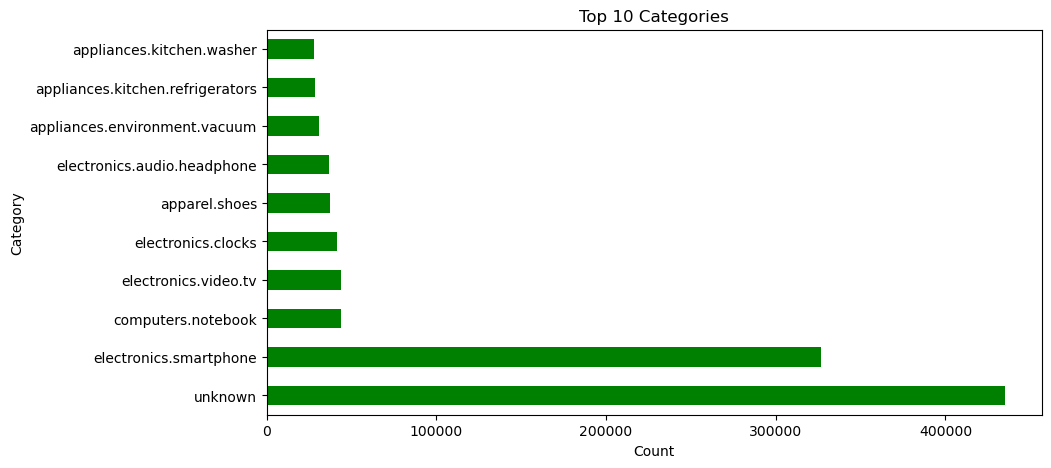

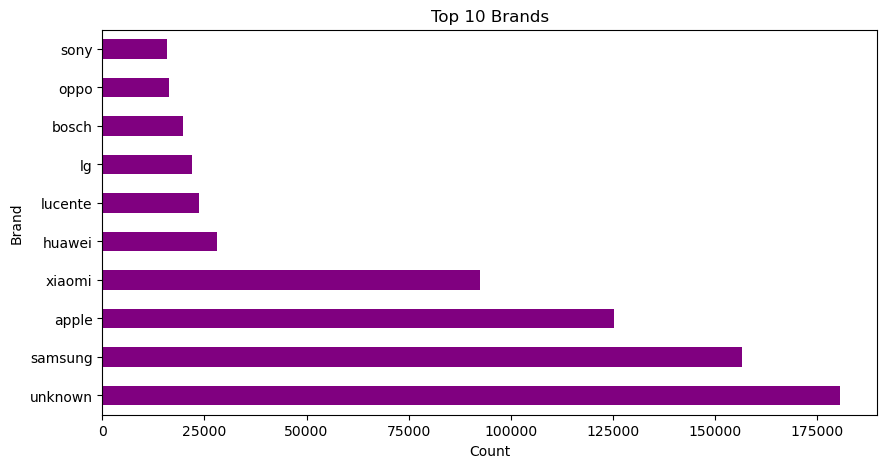

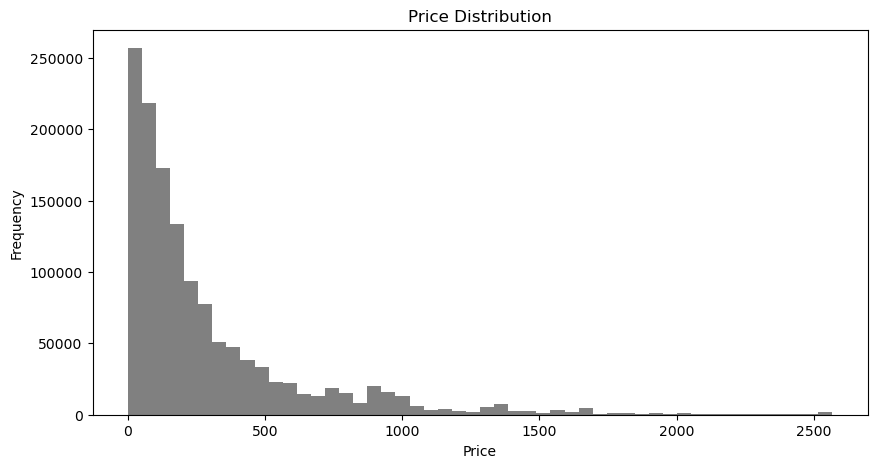

In [ ]:
# Step 4: EDA 
#Event type distribution
df["event_type"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

df["event_type"].value_counts()


#Activity by hour of day
df.groupby("hour").size().plot(kind="line", marker="o")
plt.title("User Activity by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Events")
plt.grid(True)
plt.show()


#Activity by weekday
df.groupby("weekday").size().plot(kind="bar", color="orange")
plt.title("User Activity by Day of Week")
plt.xlabel("Weekday (0 = Monday)")
plt.ylabel("Events")
plt.show()


#Top 10 categories
df["category_code"].value_counts().head(10).plot(kind="barh", color="green")
plt.title("Top 10 Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


#Top 10 brands
df["brand"].value_counts().head(10).plot(kind="barh", color="purple")
plt.title("Top 10 Brands")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.show()


#Price distribution
df["price"].plot(kind="hist", bins=50, color="gray")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Step 5: user-level features & clustering 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Separate purchases (we'll need this for total_spent)
purchases = df[df["event_type"] == "purchase"].copy()

# 2) Counts of each event type per user
user_events = (
    df.pivot_table(
        index="user_id",
        columns="event_type",
        values="product_id",
        aggfunc="count",
        fill_value=0
    )
)

# Make sure we have consistent column names
for col in ["view", "cart", "purchase"]:
    if col not in user_events.columns:
        user_events[col] = 0

user_events = user_events.rename(columns={
    "view": "num_views",
    "cart": "num_cart",
    "purchase": "num_purchases"
})

# 3) Total spent per user
total_spent = (
    purchases.groupby("user_id")["price"]
    .sum()
    .rename("total_spent")
)

# 4) Number of sessions per user
num_sessions = (
    df.groupby("user_id")["user_session"]
    .nunique()
    .rename("num_sessions")
)

# 5) Combine into one DataFrame
user_features = user_events.join([total_spent, num_sessions])
user_features = user_features.fillna(0)

# 6) Conversion rate = purchases / views
user_features["conversion_rate"] = (
    user_features["num_purchases"] /
    user_features["num_views"].replace(0, 1)   # avoid division by zero
)

print("User feature shape:", user_features.shape)
user_features.head()


User feature shape: (769660, 6)


,num_cart,num_purchases,num_views,total_spent,num_sessions,conversion_rate
user_id,,,,,,
31198833,0,0,1,0.0,1,0.0
49484535,0,0,1,0.0,1,0.0
82678143,0,0,1,0.0,1,0.0
94566147,0,0,1,0.0,1,0.0
107837897,1,0,0,0.0,1,0.0


In [ ]:
# Step 5b: KMeans clustering on user_features 

features_for_clustering = [
    "num_views",
    "num_cart",
    "num_purchases",
    "total_spent",
    "num_sessions",
    "conversion_rate"
]

X = user_features[features_for_clustering].copy()

# Remove users with no activity at all (just in case)
X = X[(X.sum(axis=1) > 0)]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans with k=4 segments 
kmeans = KMeans(n_clusters=4, random_state=42)
segments = kmeans.fit_predict(X_scaled)

# Attach segment labels back to users
user_segments = X.copy()
user_segments["segment"] = segments

# How many users in each segment?
print("Users per segment:")
print(user_segments["segment"].value_counts())


Users per segment:
segment
0    696690
2     56300
1     16668
3         2
Name: count, dtype: int64


In [ ]:
# Step 5c: describe each segment (average behavior)

segment_summary = (
    user_segments
    .groupby("segment")[features_for_clustering]
    .mean()
    .round(2)
)

segment_summary


,num_views,num_cart,num_purchases,total_spent,num_sessions,conversion_rate
segment,,,,,,
0,1.32,0.06,0.00,0.00,1.26,0.00
1,1.04,0.18,1.05,322.08,1.98,0.88
2,5.82,0.22,0.01,1.38,4.72,0.00
3,397.50,0.00,0.00,0.00,397.50,0.00


In [ ]:
# Step 6a: Build user–item matrix for collaborative filtering.

from sklearn.metrics.pairwise import cosine_similarity

# Use only purchase events
purchases_only = df[df["event_type"] == "purchase"].copy()

print("Number of purchase rows:", len(purchases_only))
print("Unique users with purchases:", purchases_only["user_id"].nunique())
print("Unique products purchased:", purchases_only["product_id"].nunique())

# To keep memory manageable, keep only "active" users/items
min_user_purchases = 2   # users must have bought at least 2 items
min_item_purchases = 5   # items must be bought by at least 5 users

user_counts = purchases_only["user_id"].value_counts()
item_counts = purchases_only["product_id"].value_counts()

valid_users = user_counts[user_counts >= min_user_purchases].index
valid_items = item_counts[item_counts >= min_item_purchases].index

p_small = purchases_only[
    purchases_only["user_id"].isin(valid_users) &
    purchases_only["product_id"].isin(valid_items)
].copy()

print("Filtered purchases for CF:", p_small.shape)

# Build user–item matrix: rows=user, columns=product, values=number of purchases
user_item = (
    p_small
    .groupby(["user_id", "product_id"])
    .size()
    .unstack(fill_value=0)
)

user_item.shape


Number of purchase rows: 18356
Unique users with purchases: 17471
Unique products purchased: 5990
Filtered purchases for CF: (1078, 13)


(578, 275)

In [ ]:
# Step 6b: Compute item–item cosine similarity 

# Transpose: products × users
item_user = user_item.T   # rows = products, cols = users

# Cosine similarity between product vectors
item_sim_matrix = cosine_similarity(item_user)

# Put into a DataFrame for easier lookup
item_sim_df = pd.DataFrame(
    item_sim_matrix,
    index=item_user.index,
    columns=item_user.index
)

item_sim_df.iloc[:5, :5]


product_id,1002524,1002525,1002528,1002531,1002532
product_id,,,,,
1002524,1.0,0.0,0.0,0.0,0.0
1002525,0.0,1.0,0.0,0.0,0.0
1002528,0.0,0.0,1.0,0.0,0.0
1002531,0.0,0.0,0.0,1.0,0.0
1002532,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Step 6c: Recommendation function (item-based CF) 

def recommend_for_user(user_id, top_n=10):
    """
    Recommend products for a user based on item-based collaborative filtering.
    - Look at items the user already purchased
    - Sum similarities to those items
    - Exclude already purchased items
    """
    if user_id not in user_item.index:
        print("User has no purchases in this filtered set.")
        return pd.Series(dtype=float)

    # Items this user has purchased
    user_row = user_item.loc[user_id]
    purchased_items = user_row[user_row > 0].index

    # Start with zero scores for all items
    scores = pd.Series(0.0, index=user_item.columns)

    # For each purchased item, add its similarity scores
    for pid in purchased_items:
        scores += item_sim_df[pid]

    # Remove items the user already bought
    scores = scores.drop(purchased_items, errors="ignore")

    # Return top N recommended items
    return scores.sort_values(ascending=False).head(top_n)


In [ ]:
# Step 6d: Try recommendations for an example user

example_user = user_item.index[0]   # just pick the first user
print("Example user ID:", example_user)

recs = recommend_for_user(example_user, top_n=10)
recs


Example user ID: 512369885


product_id
5100610    0.433013
5701086    0.102062
1005009    0.102062
4804718    0.072169
1005105    0.039284
4804055    0.036084
1005238    0.034021
1003317    0.034021
1004249    0.020833
1005100    0.018042
dtype: float64

In [49]:
# Helper to show more info for recommended items
def show_recommendations(user_id, top_n=10):
    rec_scores = recommend_for_user(user_id, top_n)
    if rec_scores.empty:
        return pd.DataFrame()

    rec_df = (
        df[df["product_id"].isin(rec_scores.index)]
        [["product_id", "category_code", "brand", "price"]]
        .drop_duplicates("product_id")
        .set_index("product_id")
        .loc[rec_scores.index]
    )
    rec_df["score"] = rec_scores.values
    return rec_df

show_recommendations(example_user, top_n=10)


,category_code,brand,price,score
product_id,,,,
5100610,electronics.clocks,apple,334.34,0.433013
5701086,auto.accessories.player,pioneer,127.42,0.102062
1005009,electronics.smartphone,xiaomi,85.97,0.102062
4804718,electronics.audio.headphone,apple,360.09,0.072169
1005105,electronics.smartphone,apple,1348.28,0.039284
4804055,electronics.audio.headphone,apple,188.94,0.036084
1005238,electronics.smartphone,oppo,282.89,0.034021
1003317,electronics.smartphone,apple,928.18,0.034021
1004249,electronics.smartphone,apple,722.40,0.020833


In [ ]:
# Step 7a: time-aware popularity per category 

# We only use purchases for demand signal
purchases = df[df["event_type"] == "purchase"].copy()

# 1) Popularity by (hour, category)
hour_cat_counts = (
    purchases
    .groupby(["hour", "category_code"])
    .size()
    .reset_index(name="count")
)

# Normalize within each hour → probability distribution
hour_cat_probs = hour_cat_counts.copy()
hour_cat_probs["prob"] = (
    hour_cat_probs["count"] /
    hour_cat_probs.groupby("hour")["count"].transform("sum")
)

# 2) Popularity by (weekday, category)
weekday_cat_counts = (
    purchases
    .groupby(["weekday", "category_code"])
    .size()
    .reset_index(name="count")
)

# Normalize within each weekday → probability distribution
weekday_cat_probs = weekday_cat_counts.copy()
weekday_cat_probs["prob"] = (
    weekday_cat_probs["count"] /
    weekday_cat_counts.groupby("weekday")["count"].transform("sum")
)

# Show examples
hour_cat_probs.head(), weekday_cat_probs.head()


(   hour                      category_code  count      prob
 0     0                      apparel.shoes      2  0.038462
 1     0                 apparel.shoes.keds      1  0.019231
 2     0  appliances.environment.air_heater      1  0.019231
 3     0      appliances.environment.vacuum      1  0.019231
 4     0       appliances.kitchen.microwave      1  0.019231,
    weekday       category_code  count      prob
 0        0     accessories.bag      7  0.003248
 1        0  accessories.wallet      2  0.000928
 2        0     apparel.costume      3  0.001392
 3        0       apparel.dress      1  0.000464
 4        0       apparel.shirt      1  0.000464)

In [ ]:
# Step 7b: product -> category mapping 
product_info = (
    df[["product_id", "category_code", "brand", "price"]]
    .drop_duplicates("product_id")
    .set_index("product_id")
)

product_info.head()


,category_code,brand,price
product_id,,,
22700890,unknown,unknown,340.60
1003317,electronics.smartphone,apple,928.18
1004322,electronics.smartphone,huawei,334.37
12100045,kids.skates,xiaomi,367.55
4801607,electronics.audio.headphone,defender,10.30


In [ ]:
#  Step 7c: time-aware recommendation 

def get_hour_cat_weight(hour, category):
    row = hour_cat_probs[
        (hour_cat_probs["hour"] == hour) &
        (hour_cat_probs["category_code"] == category)
    ]
    if row.empty:
        return 0.0
    return float(row["prob"].iloc[0])

def get_weekday_cat_weight(weekday, category):
    row = weekday_cat_probs[
        (weekday_cat_probs["weekday"] == weekday) &
        (weekday_cat_probs["category_code"] == category)
    ]
    if row.empty:
        return 0.0
    return float(row["prob"].iloc[0])


def recommend_for_user_time_aware(user_id, current_hour, current_weekday, top_n=10,
                                  alpha=0.5, beta=0.5):
    """
    Start from collaborative-filtering scores,
    then boost items whose categories are popular at the given hour/weekday.
    alpha, beta control how strong the time effect is.
    """
    base_scores = recommend_for_user(user_id, top_n=None)
    if base_scores.empty:
        return pd.DataFrame()

    # Convert to DataFrame with product info
    rec_df = (
        product_info
        .loc[base_scores.index]
        .copy()
    )
    rec_df["base_score"] = base_scores.values

    # Add time-based weights
    hour_weights = []
    weekday_weights = []

    for pid in rec_df.index:
        cat = rec_df.loc[pid, "category_code"]
        h_w = get_hour_cat_weight(current_hour, cat)
        d_w = get_weekday_cat_weight(current_weekday, cat)
        hour_weights.append(h_w)
        weekday_weights.append(d_w)

    rec_df["hour_pop"] = hour_weights
    rec_df["weekday_pop"] = weekday_weights

    # Final score = base + alpha * hour_pop + beta * weekday_pop
    rec_df["final_score"] = (
        rec_df["base_score"] +
        alpha * rec_df["hour_pop"] +
        beta * rec_df["weekday_pop"]
    )

    # Sort and keep top_n
    rec_df = rec_df.sort_values("final_score", ascending=False).head(top_n)

    return rec_df[["category_code", "brand", "price", "base_score",
                   "hour_pop", "weekday_pop", "final_score"]]


In [ ]:
# Step 7d: example usage 

example_user = user_item.index[0]   # same as before
current_hour = 20       # e.g., 8pm
current_weekday = 4     # e.g., Friday

time_aware_recs = recommend_for_user_time_aware(
    example_user,
    current_hour=current_hour,
    current_weekday=current_weekday,
    top_n=10
)

time_aware_recs


,category_code,brand,price,base_score,hour_pop,weekday_pop,final_score
product_id,,,,,,,
1005009,electronics.smartphone,xiaomi,85.97,0.102062,0.434783,0.461576,0.550241
1005105,electronics.smartphone,apple,1348.28,0.039284,0.434783,0.461576,0.487463
1005238,electronics.smartphone,oppo,282.89,0.034021,0.434783,0.461576,0.482200
1003317,electronics.smartphone,apple,928.18,0.034021,0.434783,0.461576,0.482200
1004249,electronics.smartphone,apple,722.40,0.020833,0.434783,0.461576,0.469013
1005100,electronics.smartphone,samsung,139.68,0.018042,0.434783,0.461576,0.466221
1004836,electronics.smartphone,samsung,229.90,0.017010,0.434783,0.461576,0.465190
5100610,electronics.clocks,apple,334.34,0.433013,0.038043,0.022860,0.463464
1004856,electronics.smartphone,samsung,128.18,0.010942,0.434783,0.461576,0.459121


In [ ]:
# Step 8a: Session–product funnel (view → cart → purchase) 

# Sort for nice ordering
df_sorted = df.sort_values(["user_id", "user_session", "event_time"])

# For each (user, session, product), detect which events happened
session_product_funnel = (
    df_sorted
    .groupby(["user_id", "user_session", "product_id"])
    .agg(
        first_time=("event_time", "min"),
        last_time=("event_time", "max"),
        viewed=("event_type", lambda x: (x == "view").any()),
        added_to_cart=("event_type", lambda x: (x == "cart").any()),
        purchased=("event_type", lambda x: (x == "purchase").any())
    )
    .reset_index()
)

session_product_funnel.head()


,user_id,user_session,product_id,first_time,last_time,viewed,added_to_cart,purchased
0,31198833,dbd84cb9-75db-42f6-88ec-dad77d71ccfb,1004767,2019-11-13 02:11:07+00:00,2019-11-13 02:11:07+00:00,True,False,False
1,49484535,e225514f-8ade-4f6c-9605-9481f4e608ea,12702774,2019-11-19 16:19:23+00:00,2019-11-19 16:19:23+00:00,True,False,False
2,82678143,98aa2dc0-46aa-465d-8694-e7ab9275fc8a,26011858,2019-11-21 03:04:24+00:00,2019-11-21 03:04:24+00:00,True,False,False
3,94566147,3c4da186-6885-4170-9346-a2c835c44694,1005007,2019-11-12 08:03:18+00:00,2019-11-12 08:03:18+00:00,True,False,False
4,107837897,8c62cf51-971c-46fc-8d06-9ec85e3a0740,4700557,2019-11-29 05:00:04+00:00,2019-11-29 05:00:04+00:00,False,True,False


In [ ]:
# Step 8b: Overall funnel statistics 

total_viewed = session_product_funnel["viewed"].sum()
total_cart   = session_product_funnel["added_to_cart"].sum()
total_purch  = session_product_funnel["purchased"].sum()

print("Sessions with view:     ", total_viewed)
print("Sessions with cart:     ", total_cart)
print("Sessions with purchase: ", total_purch)

# Abandoned cart: cart happened but no purchase
abandoned = session_product_funnel[
    session_product_funnel["added_to_cart"] & ~session_product_funnel["purchased"]
]

abandoned_rate = len(abandoned) / max(total_cart, 1)

print("\nAbandoned cart sessions:", len(abandoned))
print("Abandoned cart rate:    {:.2%}".format(abandoned_rate))


Sessions with view:      1250647
Sessions with cart:      59504
Sessions with purchase:  18320

Abandoned cart sessions: 59054
Abandoned cart rate:    99.24%


In [ ]:
# Step 8c: Visualize a single customer journey for one session

def show_customer_journey(user_id, session_id):
    """
    Show the sequence of events for a given user + session.
    """
    sub = (
        df_sorted[
            (df_sorted["user_id"] == user_id) &
            (df_sorted["user_session"] == session_id)
        ]
        .sort_values("event_time")
        [["event_time", "event_type", "product_id", "category_code", "brand", "price"]]
    )
    return sub

# Pick an example from the funnel
example_row = session_product_funnel.iloc[0]
ex_user = example_row["user_id"]
ex_session = example_row["user_session"]

print("Example journey — user:", ex_user, "session:", ex_session)
show_customer_journey(ex_user, ex_session)


Example journey — user: 31198833 session: dbd84cb9-75db-42f6-88ec-dad77d71ccfb


,event_time,event_type,product_id,category_code,brand,price
438645,2019-11-13 02:11:07+00:00,view,1004767,electronics.smartphone,samsung,243.51


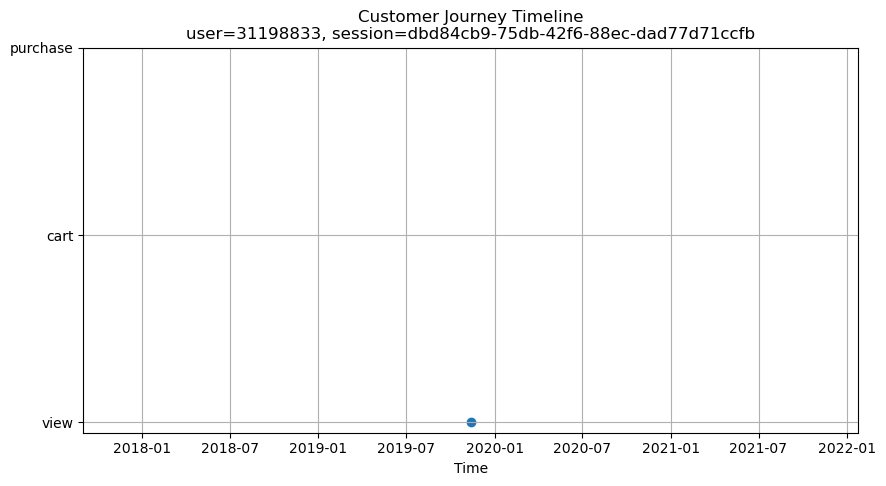

In [ ]:
# simple event timeline plot for the same journey
journey = show_customer_journey(ex_user, ex_session)

event_to_y = {"view": 0, "cart": 1, "purchase": 2}
y = journey["event_type"].map(event_to_y)

plt.figure()
plt.scatter(journey["event_time"], y)
plt.yticks([0,1,2], ["view", "cart", "purchase"])
plt.title(f"Customer Journey Timeline\nuser={ex_user}, session={ex_session}")
plt.xlabel("Time")
plt.grid(True)
plt.show()
